# **第三章: 多被试分析**

***

多被试分析的这一章分成了以下三个部分：

- **第一节: 批处理读取与存储数据**
- **第二节: 事件相关电位分析**  
- **第三节: 时频分析**

## 下载并导入需要用到的Python包

In [1]:
! pip install gdown

import numpy as np
import os
import gdown
import zipfile
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp, ttest_rel
from mne.stats import fdr_correction, f_mway_rm
from neurora.stuff import clusterbased_permutation_1d_1samp_1sided, \
                          permutation_test, \
                          clusterbased_permutation_2d_1samp_2sided, \
                          clusterbased_permutation_2d_2sided
from mne.time_frequency import tfr_array_morlet

# 第一节 - 批处理读取与存储数据

### **预处理过的Demo数据1**：  
（你将会在第二节和第三节中使用）  
原数据集基于Wakeman&Henson于2015年发表在Scientific Data上的文章《A multi-subject, multi-modal human neuroimaging dataset》  
在这个实验中，共有三种类型的面孔，分别为熟悉面孔、不熟悉面孔和乱相面孔，各150张图像，共450张刺激图像  
被试佩戴脑电进行简单的知觉任务，800-1000ms不定的刺激阶段+1700ms的延迟+400-600ms不定的ITI  
每张图片会被看到两次，第二次50%的刺激图像可能是紧接着第一次的下一个试次马上又重复观看同一图像，50%间隔较多试次后再呈现  
这里仅提取前8个被试对多张熟悉面孔图像第一次观看和对这其中一部分图像紧接着下一个试次又重复观看的试次的脑电数据

In [2]:
# 下载Demo数据1

data_dir = "data/"
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

# 从Google Drive下载
url = "https://drive.google.com/file/d/1hsPmIFod3c7ZR0YdyO8woqUfqO_3pZtR/view?usp=sharing"
filename = "demo_data1"
filepath = data_dir + filename + ".zip"

# 下载数据
gdown.download(url=url, output=filepath, quiet=False, fuzzy=True)
print("Download completes!")
# 解压数据
with zipfile.ZipFile(filepath, 'r') as zip:
    zip.extractall(data_dir)
print("Unzip completes!")

# 也可以通过百度网盘下载
# 链接:https://pan.baidu.com/s/173Hjnt-JOw0BpIm5OEx9kg  密码:2u7y
# 下载后解压，并移动到data文件夹下

Downloading...
From (original): https://drive.google.com/uc?id=1hsPmIFod3c7ZR0YdyO8woqUfqO_3pZtR
From (redirected): https://drive.google.com/uc?id=1hsPmIFod3c7ZR0YdyO8woqUfqO_3pZtR&confirm=t&uuid=64c004fa-0289-4fe3-9cc3-c66c63609f2e
To: /Users/zitonglu/Downloads/Python-EEG-Handbook-master/data/demo_data1.zip
100%|████████████████████████████████████████| 242M/242M [00:28<00:00, 8.43MB/s]


Download completes!
Unzip completes!


以sub1为例，'sub1.mat'为对熟悉面孔图像第一次观看的脑电数据，'sub1_rep.mat'为对熟悉面孔马上重复观看第二次的脑电数据  
前一情况试次数为后一情况试次数一倍，数据为进行过预处理（0.1-30Hz滤波）并分好段之后的数据  
数据中，导联数为74（其中脑电导联为70个，第61， 62， 63， 64个导联为眼动导联），采样率为250Hz  
从刺激呈现的前0.5s到刺激呈现后的1.5s，每个试次包含500个时间点

### 批处理读取Demo数据1并存成.h5文件

In [3]:
# 对8个被试的数据进行遍历
for sub in range(8):

    # 获取每个被试的两个条件下的.mat文件地址
    subdata_first_path = 'data/demo_data1/sub' + str(sub + 1) + '_first.mat'
    subdata_rep_path = 'data/demo_data1/sub' + str(sub + 1) + '_rep.mat'

    # 通过.mat文件提取数据
    # 数据shape为[n_channels, n_times, n_trials]
    subdata_first = sio.loadmat(subdata_first_path)['data']
    subdata_rep = sio.loadmat(subdata_rep_path)['data']

    # 由于导联中有四个导联是眼电导联，需要进行删去
    subdata_first = np.delete(np.array(subdata_first), [60, 61, 62, 63], axis=0)
    subdata_rep = np.delete(np.array(subdata_rep), [60, 61, 62, 63], axis=0)

    # 打印被试编号及熟悉面孔第一看到和紧接着重复看到两条件下的脑电矩阵shape
    print('sub' + str(sub + 1))
    print(subdata_first.shape)
    print(subdata_rep.shape)

    # 将每个被试两刺激条件下的脑电数据（矩阵形式）以‘data’和'data_rep'为Keys存在一个.h5文件里
    f = h5py.File('data/demo_data1/sub' + str(sub + 1) + '.h5', 'w')
    f.create_dataset('data_first', data=subdata_first)
    f.create_dataset('data_rep', data=subdata_rep)
    f.close()

sub1
(70, 500, 150)
(70, 500, 78)
sub2
(70, 500, 150)
(70, 500, 79)
sub3
(70, 500, 150)
(70, 500, 74)
sub4
(70, 500, 150)
(70, 500, 68)
sub5
(70, 500, 150)
(70, 500, 67)
sub6
(70, 500, 150)
(70, 500, 70)
sub7
(70, 500, 150)
(70, 500, 77)
sub8
(70, 500, 150)
(70, 500, 70)


# 第二节 - 事件相关电位分析

#### 这里，我们将使用Demo数据1为例 
我们将分别对实验中熟悉面孔首次观看与熟悉面孔立即重复观看两条件下的数据进行ERP的统计分析与可视化

### 读取数据与叠加平均

此例里以第50个导联的ERP示例，选取-200ms到1000ms部分

In [4]:
# 初始化2个变量分别存储每个被试两条件下的ERP
# 8 - n_subjects, 300 - n_times （-200ms到1000ms）
erp_first = np.zeros([8, 300])
erp_rep = np.zeros([8, 300])

# 逐被试迭代
for sub in range(8):

    # 读取该被试的数据
    with h5py.File('data/demo_data1/sub' + str(sub + 1) + '.h5', 'r') as f:
        subdata_first = np.array(f['data_first'])
        subdata_rep = np.array(f['data_rep'])
        f.close()
    # subdata和subdata_rep的shape均为[n_channels, n_times, n_trials]

    # 选取第50个导联的数据，平均试次，并取-200ms到1000ms
    erp_first[sub] = np.average(subdata_first[49], axis=1)[75:375]
    erp_rep[sub] = np.average(subdata_rep[49], axis=1)[75:375]

    # 基线校正，取基线为-100到0ms
    erp_first[sub] = erp_first[sub] - np.average(erp_first[sub, 25:50])
    erp_rep[sub] = erp_rep[sub] - np.average(erp_rep[sub, 25:50])

### 统计分析与结果可视化

#### 定义一个可视化ERP结果的函数 - plot_erp_results()

In [5]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

#### 绘制首次观看熟悉面孔条件下的ERP

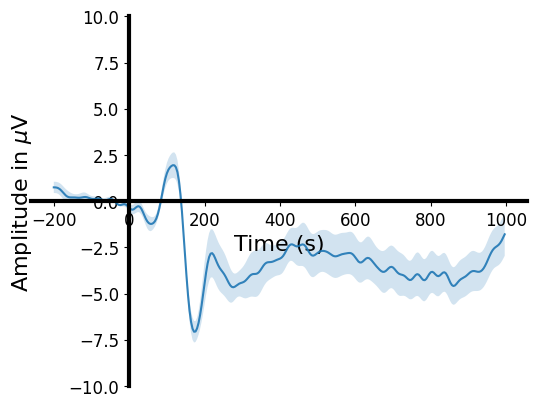

In [6]:
times = np.arange(-200, 1000, 4)
plot_erp_results(erp_first, times, labelpad=25)

#### 绘制立即重复观看熟悉面孔条件下的ERP

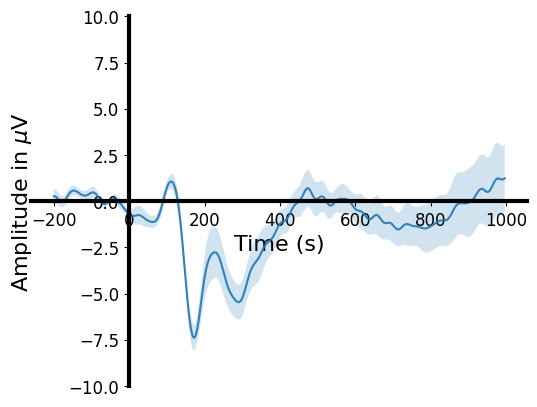

In [7]:
plot_erp_results(erp_rep, times, labelpad=25)

#### 定义一个可视化两条件下ERP结果的函数 - plot_erp_2cons_results()   

In [8]:
def plot_erp_2cons_results(erp1, erp2, times, con_labels=['Condition1', 'Condition2'], ylim=[-10, 10],
                     p_threshold=0.05, labelpad=0):

    """
    参数：
        erp1: shape为[n_subs, n_times]的矩阵，对应每个被试条件1下的ERP
        erp2: shape为[n_subs, n_times]的矩阵，对应每个被试条件2下的ERP
        con_labels: 一个List或array，[条件1名称，条件2名称]，
                    默认为['Condition1', 'Condition2']
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        con_labels: 条件标签，默认['Condition 1', 'Condition 2']
        ylim：Y轴范围，默认[-10, 10]
        p_threshold : 一个浮点型数字，默认为0.05，代表p值的阈值
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp1)[0]

    # 平均ERPs
    avg1 = np.average(erp1, axis=0)
    avg2 = np.average(erp2, axis=0)
    # calcualte the SEM for each time-point
    err1 = np.std(erp1, axis=0, ddof=0)/np.sqrt(n_subjects)
    err2 = np.std(erp2, axis=0, ddof=0)/np.sqrt(n_subjects)

    # 统计分析
    t_vals, p_vals = ttest_rel(erp1, erp2, axis=0)
    # FDR矫正
    # rejects, p_fdr_corrected = fdr_correction(p_vals, alpha=p_threshold)
            
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))
    
    # 标记显著时间窗
    tstep = (times[-1]-times[0])/len(times)
    for i, p_val in enumerate(p_vals):
        if p_val < 0.05:
            plt.fill_between([times[i], times[i]+tstep], [ylim[1]], [ylim[0]],
                             facecolor='gray', alpha=0.1)

    # 绘制带统计结果的ERP
    plt.fill_between(times, avg1+err1, avg1-err1, alpha=0.2, label=con_labels[0])
    plt.fill_between(times, avg2+err2, avg2-err2, alpha=0.2, label=con_labels[1])
    plt.plot(times, avg1, alpha=0.9)
    plt.plot(times, avg2, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(ylim[0], ylim[1])
    plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    plt.xlabel('Time (s)', fontsize=16)

    plt.legend()
    plt.show()

#### 统计并绘制首次观看与立即重复观看熟悉面孔两条件下的ERP

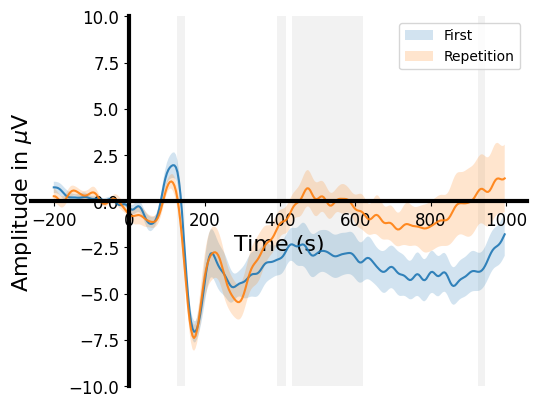

In [9]:
plot_erp_2cons_results(erp_first, erp_rep, times, con_labels=['First', 'Repetition'],
                       p_threshold=0.05, labelpad=25)

# 第三节 - 时频分析

我们分别对实验中首次观看熟悉面孔与立即重复观看熟悉面孔两条件下的数据进行时频分析

### 读取数据并进行时频分析

In [10]:
# 初始化2个变量分别存储每个被试两条件下的时频分析结果
# 8 - n_subjects, 70 - n_channels, 14 - n_freqs， 500 - n_times
tfr_first = np.zeros([8, 70, 14, 500])
tfr_rep = np.zeros([8, 70, 14, 500])

# 逐被试迭代
for sub in range(8):

    # 读取该被试的数据
    with h5py.File('data/demo_data1/sub' + str(sub + 1) + '.h5', 'r') as f:
        subdata_first = np.array(f['data_first'])
        subdata_rep = np.array(f['data_rep'])
        f.close()
    # 数据的shape从[n_channels, n_times, n_trials]转换成[n_trials, n_channels, n_times]
    subdata_first = np.transpose(subdata_first, (2, 0, 1))
    subdata_rep = np.transpose(subdata_rep, (2, 0, 1))

    # 设定一些时频分析的参数
    # 频段选取4-30Hz
    freqs = np.arange(4, 32, 2)
    n_cycles = freqs / 2.
    # 时频分析
    # 使用MNE的time_frequency模块下的tfr_arrayy_morlet()函数
    # 其输入为[n_epochs, n_channels, n_times]的array
    # 同时接着依次传入数据采样率、计算频率、周期数和输出数据类型
    subtfr_first = tfr_array_morlet(subdata_first, 250, freqs, n_cycles, output='power')
    subtfr_rep = tfr_array_morlet(subdata_rep, 250, freqs, n_cycles, output='power')
    # 此时返回的tfr的shape为[n_trials, n_channels, n_freqs, n_times]
    # 这里，对试次与导联维度平均传入tfr或tfr_rep变量中
    tfr_first[sub] = np.average(subtfr_first, axis=0)
    tfr_rep[sub] = np.average(subtfr_rep, axis=0)
    # 基线校正，这里使用'logratio'方法，即除以基线均值并取log
    # 取基线为-100到0ms
    for chl in range(70):
        for freq in range(len(freqs)):
            tfr_first[sub, chl, freq] = 10 * np.log10(tfr_first[sub, chl, freq] /
                                  np.average(tfr_first[sub, chl, freq, 100:125]))
            tfr_rep[sub, chl, freq] = 10 * np.log10(tfr_rep[sub, chl, freq] /
                                      np.average(tfr_rep[sub, chl, freq, 100:125]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    6.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

这里以第50个导联的两条件下-200ms到1000ms的时频分析结果作为后面统计分析与可视化的示例

In [11]:
tfr_first_No50 = tfr_first[:, 49, :, 75:375]
tfr_rep_No50 = tfr_rep[:, 49, :, 75:375]

### 统计分析与结果可视化

#### 定义一个绘制单条件时频分析结果的函数 - plot_tfr_results().  
这一部分包含统计分析与可视化的功能，并且对结果进行了cluster-based permutation test

In [12]:
def plot_tfr_results(tfr, freqs, times, p=0.01, clusterp=0.05, clim=[-4, 4]):

    """
    参数：
        tfr : shape为[n_subs, n_freqs, n_times]的矩阵，代表时频分析的结果
        freqs : shape为[n_freqs]的array，代表时频分析的频率（对应y轴的频率范围及频率点）
        times : shape为[n_times]的array，代表时频分析的时间点（对应x轴的时间范围及时间点）
        p : 一个浮点型数字，默认为0.01，代表p值的阈值
        clusterp : 一个浮点型数字，默认为0.05，代表cluster层面p值的阈值
        clim : 一个List或array，[最小值，最大值]，默认为[-4, 4]，代表颜色条的上下边界
    """

    n_freqs = len(freqs)
    n_times = len(times)

    # 统计分析
    # 注意：由于进行了cluster-based permutation test，需要运行较长时间
    # 这里使用NeuroRA的stuff模块下的clusterbased_permutation_2d_1samp_2sided()函数
    # 其返回的stats_results为一个shape为[n_freqs, n_times]的矩阵
    # 该矩阵中不显著的点的值为0，显著大于0的点的值为1，显著小于0的点的值为-1
    # 这里iter设成100是为了示例运行起来快一些，建议1000
    stats_results = clusterbased_permutation_2d_1samp_2sided(tfr, 0,
                                                        p_threshold=p,
                                                        clusterp_threshold=clusterp,
                                                        iter=100)

    # 时频分析结果可视化
    fig, ax = plt.subplots(1, 1)
    # 勾勒显著性区域
    padsats_results = np.zeros([n_freqs + 2, n_times + 2])
    padsats_results[1:n_freqs+1, 1:n_times + 1] = stats_results
    x = np.concatenate(([times[0]-1], times, [times[-1]+1]))
    y = np.concatenate(([freqs[0]-1], freqs, [freqs[-1]+1]))
    X, Y = np.meshgrid(x, y)
    ax.contour(X, Y, padsats_results, [0.5], colors="red", alpha=0.9,
               linewidths=2, linestyles="dashed")
    ax.contour(X, Y, padsats_results, [-0.5], colors="blue", alpha=0.9,
               linewidths=2, linestyles="dashed")
    # 绘制时频结果热力图
    im = ax.imshow(np.average(tfr, axis=0), cmap='RdBu_r', origin='lower',
                   extent=[times[0], times[-1], freqs[0], freqs[-1]], clim=clim)
    ax.set_aspect('auto')
    cbar = fig.colorbar(im)
    cbar.set_label('dB', fontsize=12)
    ax.set_xlabel('Time (ms)', fontsize=16)
    ax.set_ylabel('Frequency (Hz)', fontsize=16)
    plt.show()

In [13]:
print(tfr_first.shape)

(8, 70, 14, 500)


#### 统计并绘制首次观看熟悉面孔条件下的时频分析结果


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



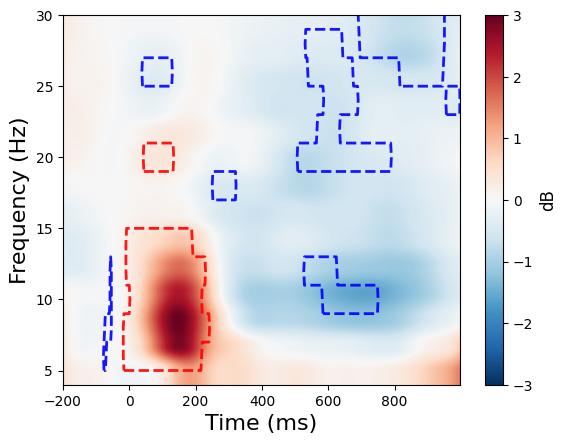

In [14]:
freqs = np.arange(4, 32, 2)
times = np.arange(-200, 1000, 4)
plot_tfr_results(tfr_first_No50, freqs, times, p=0.05, clusterp=0.05, clim=[-3, 3])

#### 统计并绘制立即重复观看熟悉面孔条件下的时频分析结果


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



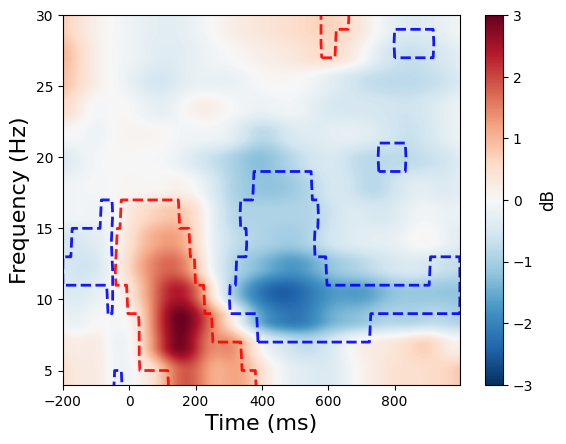

In [15]:
plot_tfr_results(tfr_rep_No50, freqs, times, p=0.05, clusterp=0.05, clim=[-3, 3])

#### 定义一个绘制两条件时频分析结果差异结果的函数 - plot_tfr_diff_results()  
这里的差异用tfr1 - tfr2计算得到  
该函数包含统计分析与可视化的功能，并且结果进行了cluster-based permutation test

In [16]:
def plot_tfr_diff_results(tfr1, tfr2, freqs, times, p=0.01, clusterp=0.05,
                          clim=[-2, 2]):

    """
    参数：
        tfr1 : shape为[n_subs, n_freqs, n_times]的矩阵，代表条件1下时频分析的结果
        tfr2 : shape为[n_subs, n_freqs, n_times]的矩阵，代表条件2下时频分析的结果
        freqs : shape为[n_freqs]的array，代表时频分析的频率（对应y轴的频率范围及频率点）
        times : shape为[n_times]的array，代表时频分析的时间点（对应x轴的时间范围及时间点）
        p : 一个浮点型数字，默认为0.01，代表p值的阈值
        clusterp : 一个浮点型数字，默认为0.05，代表cluster层面p值的阈值
        clim : 一个List或array，[最小值，最大值]，默认为[-2, 2]，代表颜色条的上下边界
    """

    n_freqs = len(freqs)
    n_times = len(times)

    # 统计分析
    # 注意：由于进行了cluster-based permutation test，需要运行较长时间
    # 这里使用NeuroRA的stuff模块下的clusterbased_permutation_2d_2sided()函数
    # 其返回的stats_results为一个shape为[n_freqs, n_times]的矩阵
    # 该矩阵中不显著的点的值为0，条件1显著大于条件2的点的值为1，条件1显著小于条件2的点的值为-1
    # 这里iter设成100是为了示例运行起来快一些，建议1000
    stats_results = clusterbased_permutation_2d_2sided(tfr1, tfr2,
                                                       p_threshold=p,
                                                       clusterp_threshold=clusterp,
                                                       iter=100)
    
    # 计算tfr差异
    tfr_diff = tfr1 - tfr2

    # 时频分析结果可视化
    fig, ax = plt.subplots(1, 1)
    # 勾勒显著性区域
    padsats_results = np.zeros([n_freqs + 2, n_times + 2])
    padsats_results[1:n_freqs + 1, 1:n_times + 1] = stats_results
    x = np.concatenate(([times[0]-1], times, [times[-1]+1]))
    y = np.concatenate(([freqs[0]-1], freqs, [freqs[-1]+1]))
    X, Y = np.meshgrid(x, y)
    ax.contour(X, Y, padsats_results, [0.5], colors="red", alpha=0.9,
               linewidths=2, linestyles="dashed")
    ax.contour(X, Y, padsats_results, [-0.5], colors="blue", alpha=0.9,
               linewidths=2, linestyles="dashed")
    # 绘制时频结果热力图
    im = ax.imshow(np.average(tfr_diff, axis=0), cmap='RdBu_r', origin='lower',
                   extent=[times[0], times[-1], freqs[0], freqs[-1]], clim=clim)
    
    ax.set_aspect('auto')
    cbar = fig.colorbar(im)
    cbar.set_label('$\Delta$dB', fontsize=12)
    ax.set_xlabel('Time (ms)', fontsize=16)
    ax.set_ylabel('Frequency (Hz)', fontsize=16)
    plt.show()

#### 统计并绘制首次观看与立即重复观看熟悉面孔两条件下的时频分析结果差异


Permutation test

Side 1 begin:
Calculating: [====================================================================================================] 100.00%
Side 1 finished!

Side 2 begin:

Calculating: [====================================================================================================] 100.00%
Side 2 finished!

Cluster-based permutation test finished!



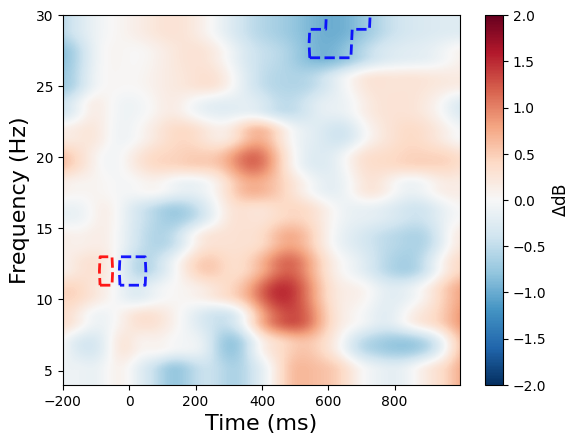

In [17]:
freqs = np.arange(4, 32, 2)
times = np.arange(-200, 1000, 4)
plot_tfr_diff_results(tfr_first_No50, tfr_rep_No50, freqs, times,
                      p=0.05, clusterp=0.05, clim=[-2, 2])